In [30]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
from scipy.stats import entropy, skew, kurtosis
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")


In [31]:
RANDOM_STATE = 42
WINDOW_SIZE = 512
STEP_SIZE = 512
BASE_PATH = r"C:\DIGITAL TWIN\dataset"

files_info = {
    "Healthy": os.path.join(BASE_PATH, "test6_healthy_D40_S0label.csv"),
    "Suction blockage at 10°": os.path.join(BASE_PATH, "test6_S10_D40label.csv"),
    "Suction blockage at 20°": os.path.join(BASE_PATH, "test6_S20_D40label.csv"),
    "Suction blockage at 30°": os.path.join(BASE_PATH, "test6_S30_D40label.csv"),
    "Suction blockage at 40°": os.path.join(BASE_PATH, "test6_SB40_D40label.csv"),
}

# Load data
all_data = []
for label, path in files_info.items():
    df = pd.read_csv(path, encoding='latin1')
    df["Class"] = label
    all_data.append(df)

data = pd.concat(all_data, ignore_index=True)
print(f"✅ Loaded {len(data)} total rows from all files")


✅ Loaded 1536000 total rows from all files


In [33]:
def extract_frequency_features(signal, axis):
    fft_vals = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal))
    spectrum = np.abs(fft_vals[:len(signal)//2])
    power = spectrum ** 2

    return {
        f"{axis}_fft_max": np.max(spectrum),
        f"{axis}_fft_mean": np.mean(spectrum),
        f"{axis}_fft_peak_freq": freqs[np.argmax(spectrum)],
        f"{axis}_fft_total_power": np.sum(power),
        f"{axis}_fft_centroid": np.sum(freqs[:len(signal)//2] * spectrum) / np.sum(spectrum),
        f"{axis}_fft_spread": np.std(spectrum),
        f"{axis}_fft_entropy": entropy(spectrum + 1e-6),
    }

def extract_features_from_window(window):
    feat = {}
    for axis in ["X Axis", "Y Axis", "Z Axis"]:
        signal = window[axis].values
        hist = np.histogram(signal, bins=10)[0] + 1
        peak = np.max(np.abs(signal))
        rms = np.sqrt(np.mean(signal ** 2))
        mav = np.mean(np.abs(signal))
        mean = np.mean(signal)
        std = np.std(signal)
        var = np.var(signal)

        feat.update({
            f"{axis}_mean": mean,
            f"{axis}_std": std,
            f"{axis}_min": np.min(signal),
            f"{axis}_max": np.max(signal),
            f"{axis}_skew": skew(signal),
            f"{axis}_kurtosis": kurtosis(signal),
            f"{axis}_entropy": entropy(hist),
            f"{axis}_abs_mean": mav,
            f"{axis}_energy": np.sum(signal ** 2),
            f"{axis}_var": var,
            f"{axis}_rms": rms,
            f"{axis}_mav": mav,
            f"{axis}_ptp": np.ptp(signal),
            f"{axis}_crest_factor": peak / rms if rms != 0 else 0,
            f"{axis}_impulse_factor": peak / mean if mean != 0 else 0,
            f"{axis}_shape_factor": rms / mav if mav != 0 else 0,
            f"{axis}_margin_factor": peak / np.sqrt(mean**2) if mean != 0 else 0,
        })

        feat.update(extract_frequency_features(signal, axis))
    return feat


In [34]:
features, labels = [], []
for label in data["Class"].unique():
    class_df = data[data["Class"] == label]
    for start in range(0, len(class_df) - WINDOW_SIZE + 1, STEP_SIZE):
        window = class_df.iloc[start:start + WINDOW_SIZE]
        feat = extract_features_from_window(window)
        feat["Class"] = label
        features.append(feat)

features_df = pd.DataFrame(features)
print(f"✅ Extracted {len(features_df)} windows.")


✅ Extracted 3000 windows.


In [35]:
# Label encoding
features_df["Target"] = features_df["Class"].astype("category").cat.codes
label_mapping = dict(enumerate(features_df["Class"].astype("category").cat.categories))
print("📊 Label Mapping:\n", label_mapping)

X = features_df.drop(columns=["Class", "Target"])
y = features_df["Target"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
)
print(f"✅ Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


📊 Label Mapping:
 {0: 'Healthy', 1: 'Suction blockage at 10°', 2: 'Suction blockage at 20°', 3: 'Suction blockage at 30°', 4: 'Suction blockage at 40°'}
✅ Training samples: 2100, Testing samples: 900


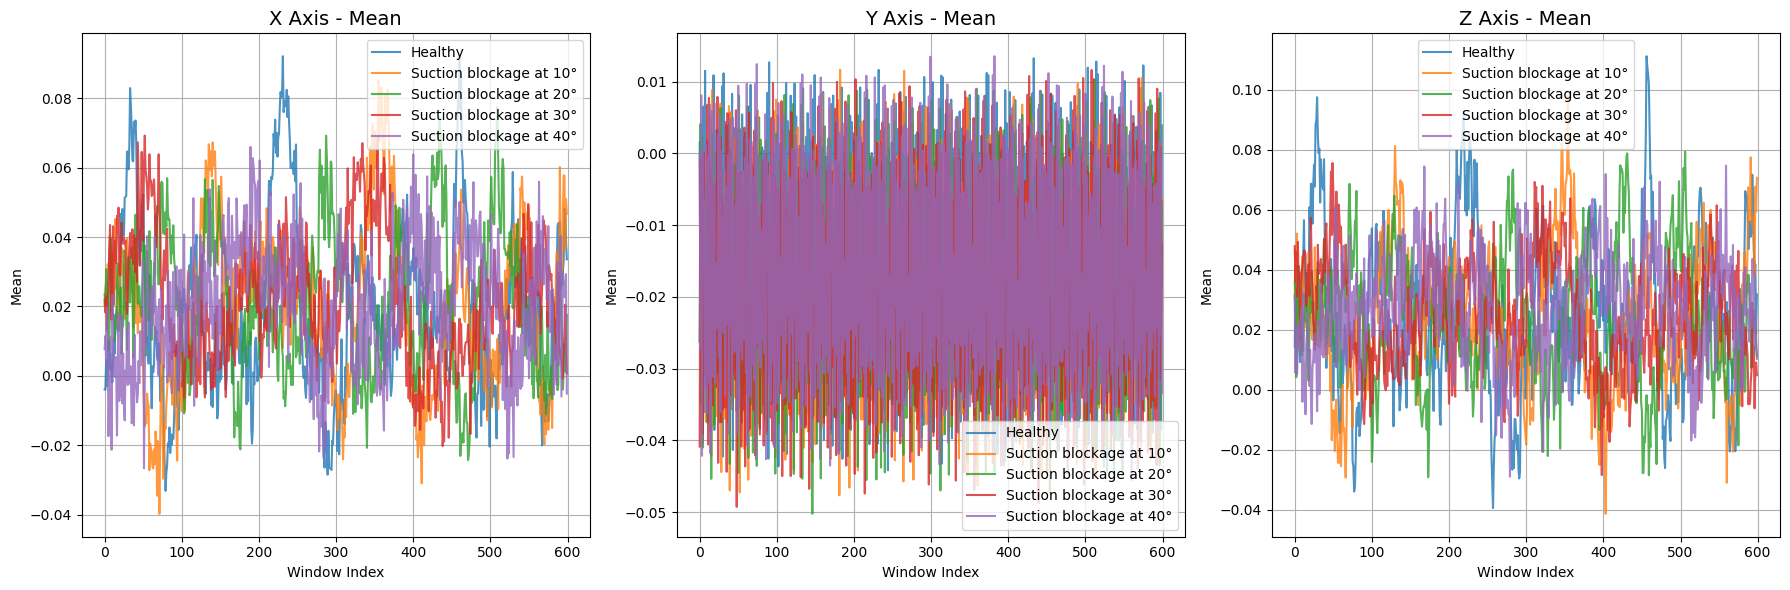

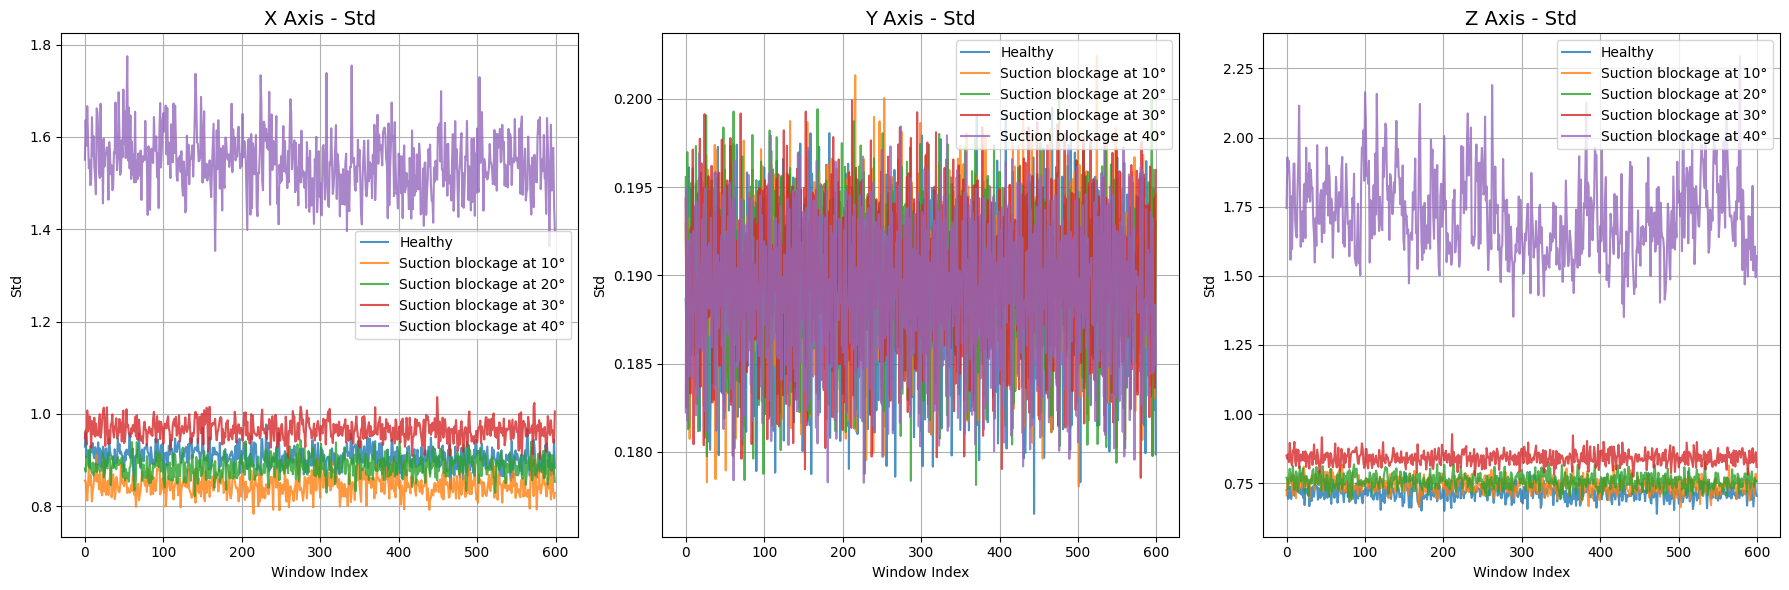

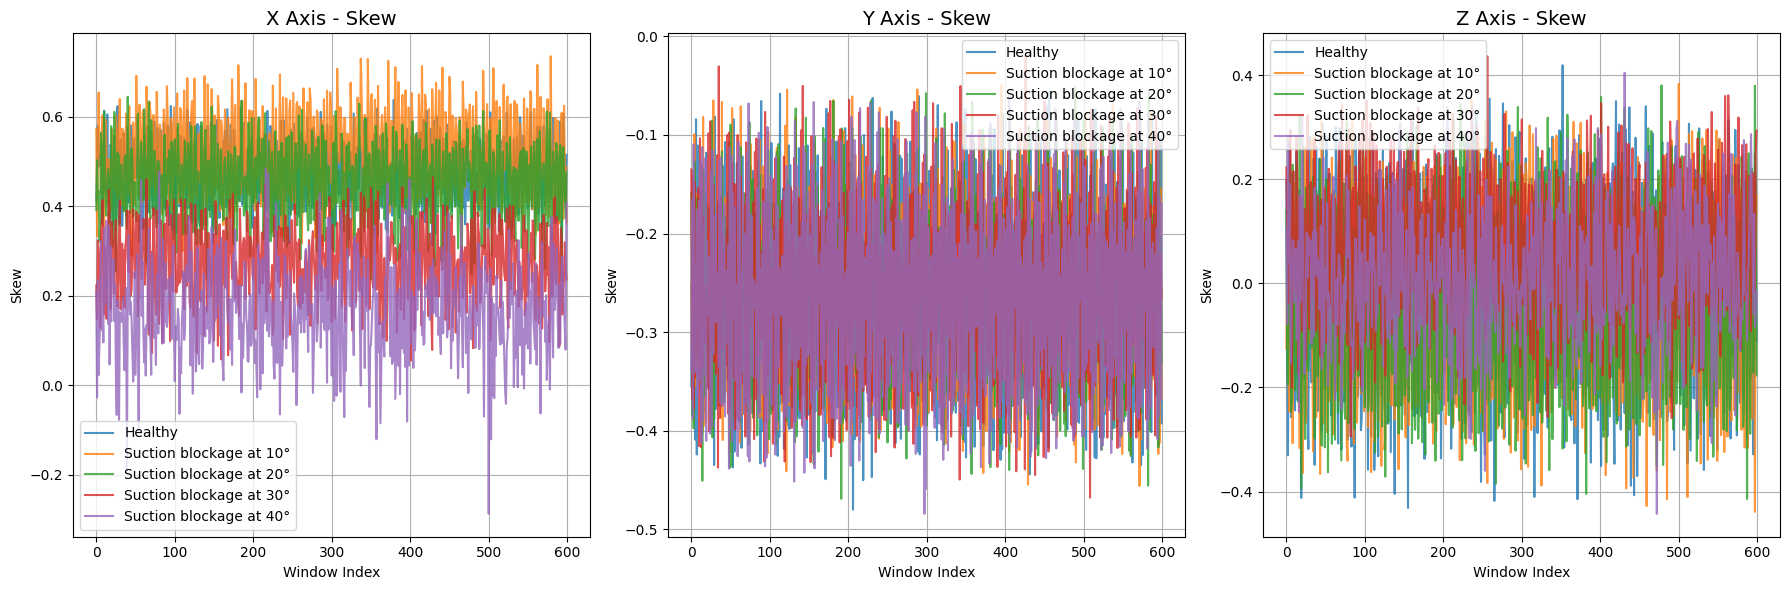

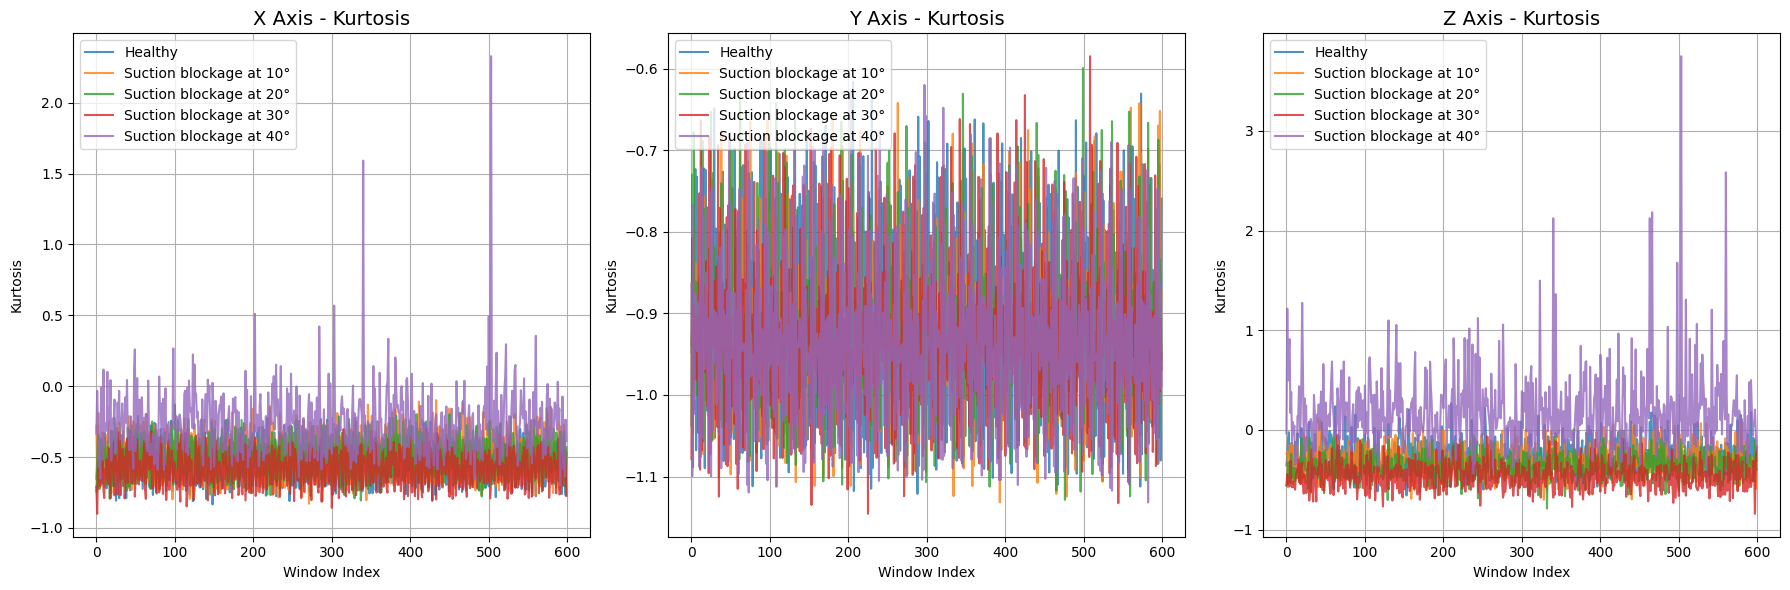

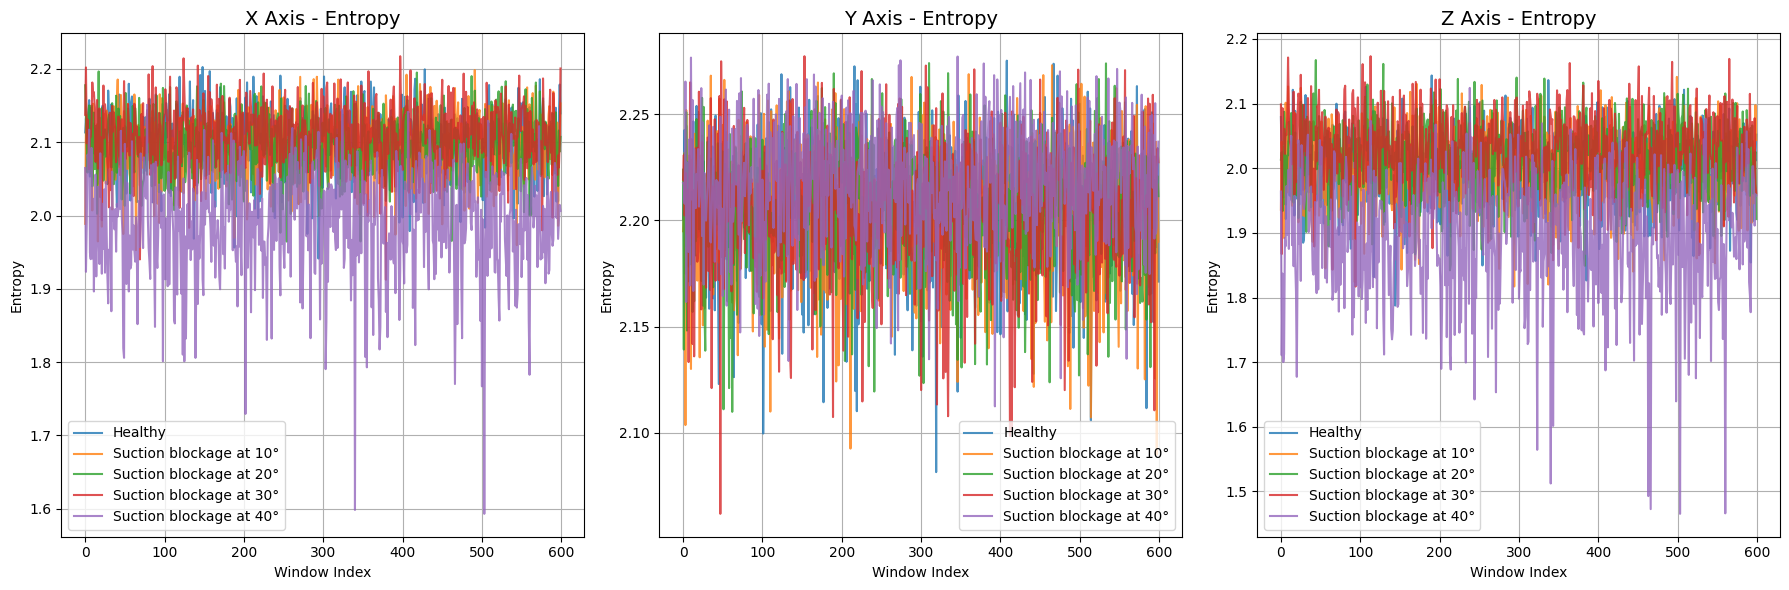

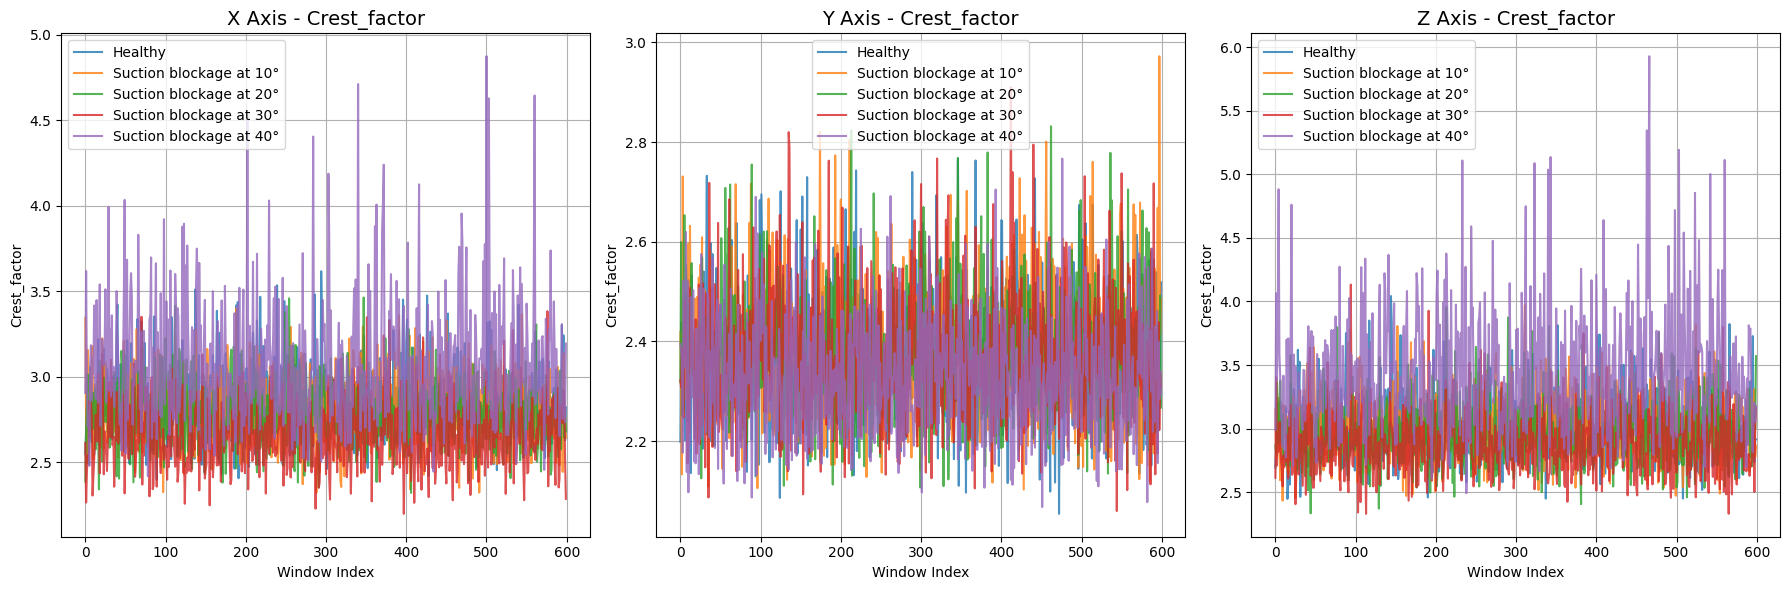

In [36]:
# Choose statistical features to plot
selected_features = [
    "mean", "std", "skew", "kurtosis", "entropy", "crest_factor"
]

# Function to plot line plots per feature and axis
def plot_feature_lineplots(features_df, selected_features, label_mapping):
    axes = ["X Axis", "Y Axis", "Z Axis"]
    class_labels = features_df["Class"].unique()
    
    for feat in selected_features:
        plt.figure(figsize=(18, 6))
        for axis in axes:
            plt.subplot(1, 3, axes.index(axis)+1)
            for label in class_labels:
                subset = features_df[features_df["Class"] == label]
                y = subset[f"{axis}_{feat}"].values
                x = np.arange(len(y))
                plt.plot(x, y, label=label, alpha=0.8)
            
            plt.title(f"{axis} - {feat.capitalize()}", fontsize=14)
            plt.xlabel("Window Index")
            plt.ylabel(f"{feat.capitalize()}")
            plt.legend()
            plt.grid(True)
        
        plt.tight_layout()
        plt.show()

# Plot features (like Figure 8 in paper)
plot_feature_lineplots(features_df, selected_features, label_mapping)


In [37]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
print("✅ After SMOTE - Balanced Classes:\n", pd.Series(y_train_resampled).value_counts())


✅ After SMOTE - Balanced Classes:
 Target
0    420
1    420
2    420
4    420
3    420
Name: count, dtype: int64


In [38]:
# Grid Search
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE),
    rf_params,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)
grid_rf.fit(X_train_resampled, y_train_resampled)
best_rf = grid_rf.best_estimator_

# Prediction & Evaluation
y_pred_rf = best_rf.predict(X_test_scaled)
print("\n🌲 Random Forest Evaluation:")
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(classification_report(y_test, y_pred_rf, target_names=label_mapping.values()))


Fitting 3 folds for each of 24 candidates, totalling 72 fits

🌲 Random Forest Evaluation:
✅ Accuracy: 0.9811
                         precision    recall  f1-score   support

                Healthy       0.99      0.98      0.99       180
Suction blockage at 10°       0.94      0.98      0.96       180
Suction blockage at 20°       0.98      0.95      0.96       180
Suction blockage at 30°       1.00      0.99      1.00       180
Suction blockage at 40°       1.00      1.00      1.00       180

               accuracy                           0.98       900
              macro avg       0.98      0.98      0.98       900
           weighted avg       0.98      0.98      0.98       900



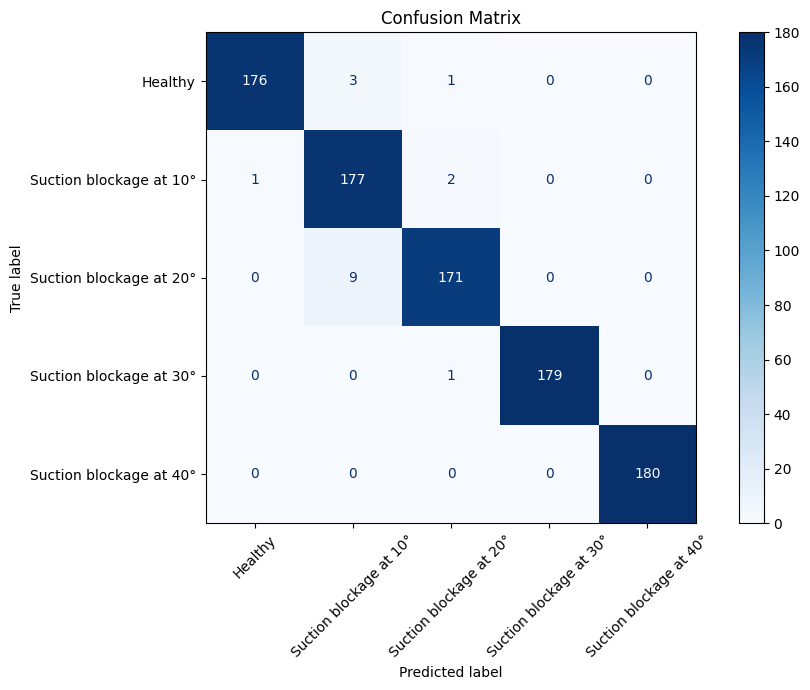

In [39]:
# Confusion matrix
def plot_confusion_matrix(y_true, y_pred, label_map):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.values()))
    fig, ax = plt.subplots(figsize=(10, 7))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test, y_pred_rf, label_mapping)


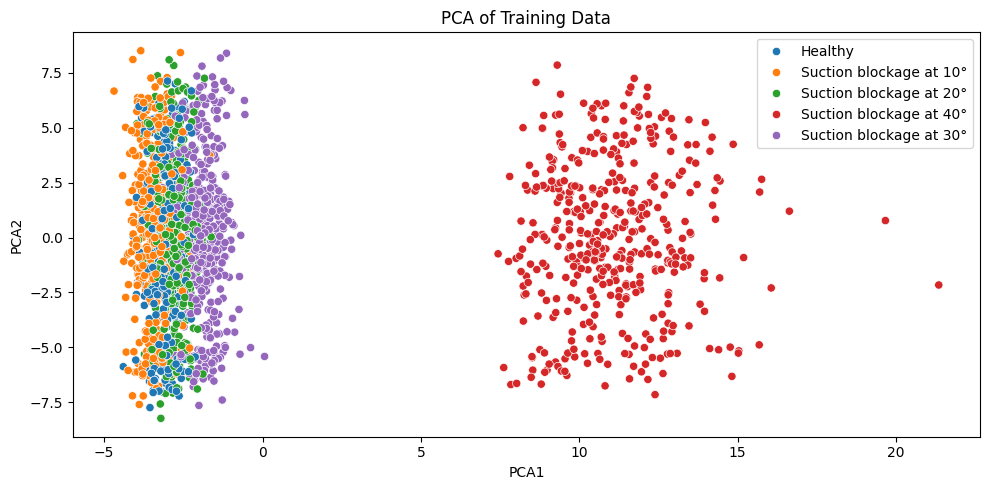

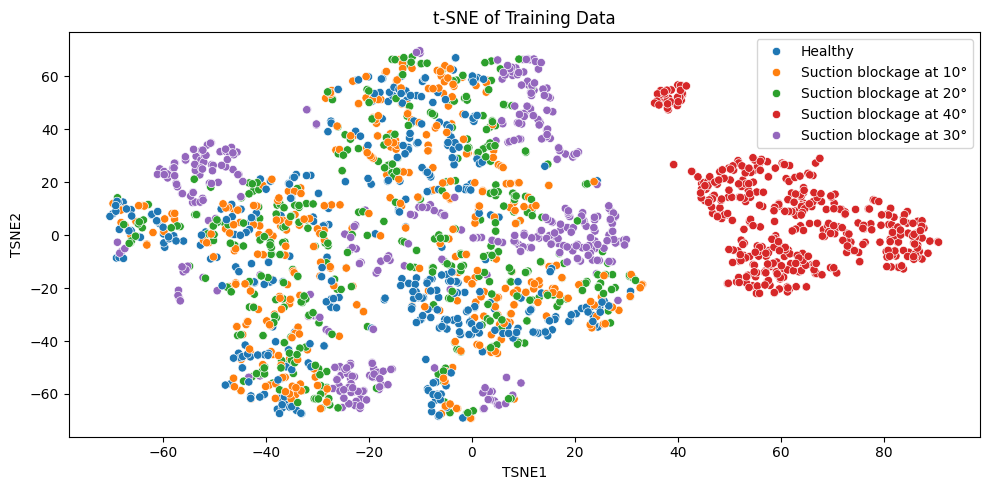

In [40]:
# PCA
pca = PCA(n_components=2, random_state=RANDOM_STATE)
pca_data = pca.fit_transform(X_train_resampled)
pca_df = pd.DataFrame(pca_data, columns=["PCA1", "PCA2"])
pca_df["Label"] = y_train_resampled.map(label_mapping)

# t-SNE
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=10)
tsne_data = tsne.fit_transform(X_train_resampled)
tsne_df = pd.DataFrame(tsne_data, columns=["TSNE1", "TSNE2"])
tsne_df["Label"] = y_train_resampled.map(label_mapping)

# PCA Plot
plt.figure(figsize=(10, 5))
sns.scatterplot(data=pca_df, x="PCA1", y="PCA2", hue="Label", palette="tab10")
plt.title("PCA of Training Data")
plt.legend()
plt.tight_layout()
plt.show()

# t-SNE Plot
plt.figure(figsize=(10, 5))
sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2", hue="Label", palette="tab10")
plt.title("t-SNE of Training Data")
plt.legend()
plt.tight_layout()
plt.show()
